In [300]:
import importlib, model, networks, linsat, datagen, utils, MIP_solvers
importlib.reload(model)
importlib.reload(networks)
importlib.reload(linsat)
importlib.reload(utils)
importlib.reload(MIP_solvers)
importlib.reload(datagen)

<module 'datagen' from '/Users/rezaramezanpour/Documents/ICASSP2025/hyp-sched-main 3/datagen.py'>

In [301]:
from utils import get_hyperedges, get_data, get_H, check_feasibility, gumbel_linsat_layer, visualize_hyperedges
from model import CustomLossBatch, utility_fn, train_handler, train_handler_batch
from datagen import generate_data
from linsat import linsat_layer_modified, linsat_layer
import torch
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from greedy_solvers import gready_scheduler
from networks import MLP
from MIP_solvers import ipopt_solver, gekko_apopt_solver
from torch.utils.data import Dataset, DataLoader


# HyperDataset

**Run this before Loading Saved Data**

In [3]:
class HyperDataset(Dataset):
    def __init__(self, I, Dv_inv, De_inv, H, W):
        self.I = I
        self.Dv_inv = Dv_inv
        self.De_inv = De_inv
        self.H = H
        self.W = W

    def __len__(self):
        return len(self.I)

    def __getitem__(self, idx):
        return self.I[idx], self.Dv_inv[idx], self.De_inv[idx], self.H[idx], self.W[idx]


def custom_collate_fn(batch):
    # Unpack the batch
    I_batch, Dv_inv_batch, De_inv_batch, H_batch, W_batch = zip(*batch)
    
    # Pad sequences or handle different sizes here
    # For simplicity, this example assumes padding tensors with `torch.nn.utils.rnn.pad_sequence`
    I_batch = torch.stack(I_batch)  # If same-sized tensors
    Dv_inv_batch = torch.stack(Dv_inv_batch)
    De_inv_batch = torch.stack(De_inv_batch)
    H_batch = torch.stack(H_batch)
    W_batch = torch.stack(W_batch)
    
    return I_batch, Dv_inv_batch, De_inv_batch, H_batch, W_batch

# Parameters

In [86]:
# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges
# N = 0.1  # Noise power
N_db = -136.87  # dB
N = 10**(N_db/10)
theta = 10  # Thresholds for hyperedges
train_samples = 1000
test_samples = 5
batch_size = 5

# Load Pre-Generated Data

**Use this data for result evaluation**</br>
<span style="color:cyan">**Skip Generate Data and Data Prepration If you are using this part**</span>

In [6]:
with open('train_dataset_n10_xylim4000.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('test_dataset_n10_xylim4000.pkl', 'rb') as f:
    test_dataset = pickle.load(f)


# defining a data loader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_samples = len(train_dataset)
test_samples = len(test_dataset)

# Generate data

In [ ]:
xy_lim = 2000
itens_train, hlist_train, locs_train = get_data(train_samples, V_H, N, xy_lim, theta)
itens_test, hlist_test, locs_test = get_data(test_samples, V_H, N, xy_lim, theta)

### get_H problem

<span style="color:red">**We don't need this part anymore**</span>

In [ ]:
H_train_list = get_H(hlist_train, train_samples)
H_test_list = get_H(hlist_test, test_samples)
H_train = torch.sparse_coo_tensor(H_train_list, torch.ones(len(H_train_list[0])), size=(train_samples, V_H, V_H))
H_test = torch.sparse_coo_tensor(H_test_list, torch.ones(len(H_test_list[0])), size=(test_samples, V_H, V_H))

# Environment Visualization

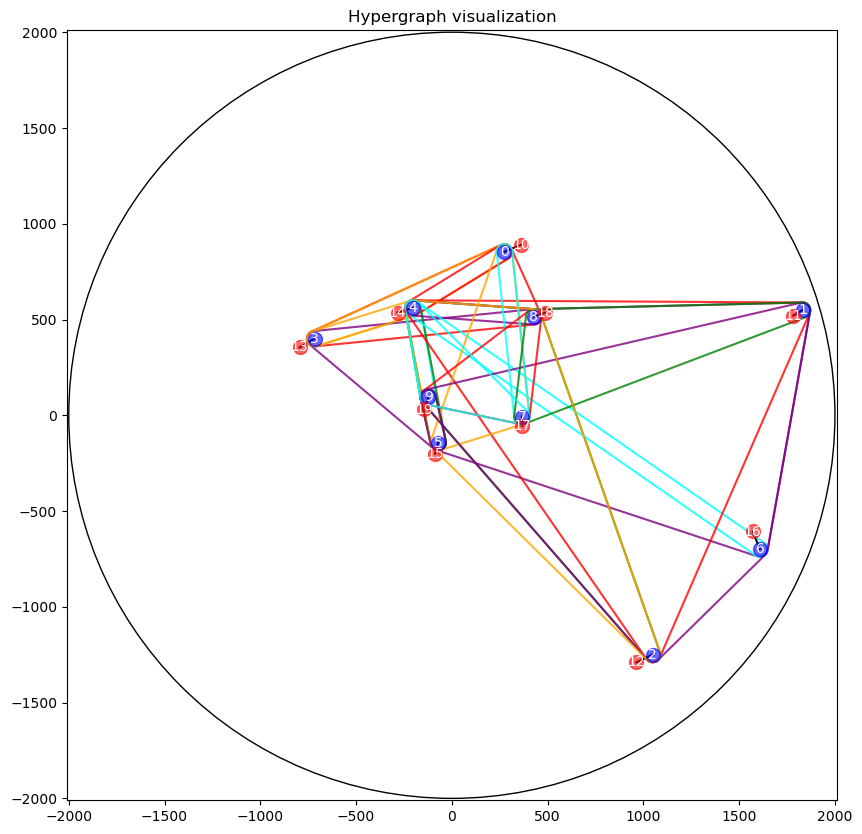

In [93]:
sample_id = 3
buffer_distance = 40 # play with this to change the shape of hyperedges
visualize_hyperedges(locs_train[sample_id], hlist_train[sample_id], buffer_distance, xy_lim)

## Data Preparation

Format of Data Should be as follows
Dictionary Keys: "$n$": Number of hypernodes ($|\mathcal{V}_H|$), "$E$": dictionray of hyperedges, "$I \in R^{n\times n}$": Interference and Power matrix, "$H \in \{0,1\}^{n\times m}$: Incident matrix ($m$ is the size of hyperedges) 

In [111]:
def sparse_diagonalize(Dv_inv):
    indices = Dv_inv.coalesce().indices()
    indices_diag = torch.vstack([indices, indices])
    values = Dv_inv.coalesce().values()
    shape = Dv_inv.shape
    Dv_inv = torch.sparse_coo_tensor(indices, values, shape)
    return Dv_inv
    

def create_sparse_tensor(hyperedges, V_H):
    row_indices = []
    col_indices = []
    values = []

    for i, hyperedge in enumerate(hyperedges):
        for node in hyperedge:
            row_indices.append(i)  # Hyperedge index
            col_indices.append(node)  # Node index
            values.append(1)  # Assuming all values are 1

    # Convert to tensors
    indices = torch.tensor([row_indices, col_indices], dtype=torch.long)
    values = torch.tensor(values, dtype=torch.float32)
    shape = (len(hyperedges), V_H)  # Determine shape

    return torch.sparse_coo_tensor(indices, values, size=shape, dtype=torch.float64)

def hypergraph_generation(V_H, I, hyperedges):
    hypergraph = {}

    

    hypergraph["I"] = torch.DoubleTensor(I)


    H = create_sparse_tensor(hyperedges, V_H)
#     Dv_inv = sparse_diagonalize(H.sum(0)**(-1/2))
#     De_inv = sparse_diagonalize(H.sum(1)**(-1))
    Dv_inv = (H.sum(0)**(-1/2)).to_dense()  # Not diagonal; We will use element-wise multiplication to save memory
    De_inv = (H.sum(1)**(-1)).to_dense()
#     W = torch.eye(V_H, dtype=torch.float64)
    W = torch.ones(De_inv.shape, dtype=torch.float64)
    hypergraph["H"] = H
    hypergraph["Dv_inv"] = Dv_inv
    hypergraph["De_inv"] = De_inv
    hypergraph["W"] = W
    return hypergraph

### Generating train and test dataste

In [181]:
hyps_train, hyps_test = [], []

# Is = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Is = []
#Dv_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
#De_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
#Hs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Dv_invs = []
De_invs = []
Hs = []
# Ws = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Ws = []

i = 0
for I, hyperedges in zip(itens_train, hlist_train):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is.append(hyp["I"])
    Dv_invs.append(hyp["Dv_inv"])
    De_invs.append(hyp["De_inv"])
    Hs.append(hyp["H"].T)
    Ws.append(hyp["W"])
    
    i += 1
Is = torch.stack(Is)
# Ws = torch.stack(Ws)
train_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)


# Is = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Is = []
#Dv_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
#De_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
#Hs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Dv_invs = []
De_invs = []
Hs = []
# Ws = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Ws = []

i = 0
for I, hyperedges in zip(itens_test, hlist_test):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is.append(hyp["I"])
    Dv_invs.append(hyp["Dv_inv"])
    De_invs.append(hyp["De_inv"])
    #Hs[i] = hyp["H"]
    Hs.append(hyp["H"].T)
    Ws.append(hyp["W"])
    i += 1
Is = torch.stack(Is)
# Ws = torch.stack(Ws)
test_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)

In [191]:
# defining a data loader
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# Exhaustive Search Solver

In [184]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    hyperedges = hyperedges.T
    best_throughput = 0
    best_schedule = None
    for i in range(2**V_H):
        schedule = np.array([int(x) for x in bin(i)[2:].zfill(V_H)])  # Numpy is faster than torch
        throughput = 0
        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            non_zero_idx = np.nonzero(hyperedge)[0]
            is_not_trivial = len(non_zero_idx) > 1
            if sum(schedule[non_zero_idx]) == len(non_zero_idx) and is_not_trivial:
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue
        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += np.log2(1+(I[i,i] * schedule[i]) / denominator)
        # print(schedule, throughput)
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

In [185]:
print("Exhaustive search results:")
best_throughput_test = []
for i, sample in enumerate(train_dataset):
    X, _, _, H, _ = sample
    best_throughput, best_schedule = exh_solver(X.shape[1], X.shape[1], X.shape[1]*[N], X.detach().to_dense().numpy(), H.detach().to_dense().numpy())
    best_throughput_test.append(best_throughput)
    # print("Optimal link schedule:", best_schedule)
    print("Optimal link schedule " , best_schedule, " Maximum throughput:", best_throughput, "bits/s/Hz")
tput_optimal_mean = np.mean(best_throughput_test)
print(f"Mean average throughput: {tput_optimal_mean}")

Exhaustive search results:
Optimal link schedule  [0 0 0 0 0 0 0 1 0 0]  Maximum throughput: 33.39108078656024 bits/s/Hz
Optimal link schedule  [0 1 1 1 0 1 1 1 0 1]  Maximum throughput: 37.47928236753793 bits/s/Hz
Optimal link schedule  [0 0 0 0 0 0 1 0 0 0]  Maximum throughput: 33.54192619194579 bits/s/Hz
Optimal link schedule  [0 1 0 0 0 0 0 0 0 0]  Maximum throughput: 33.43271096364377 bits/s/Hz
Optimal link schedule  [0 0 1 0 0 0 0 0 0 0]  Maximum throughput: 36.13426892141139 bits/s/Hz
Optimal link schedule  [0 0 0 0 0 0 0 0 1 0]  Maximum throughput: 33.476580485783295 bits/s/Hz
Optimal link schedule  [0 1 1 0 1 1 1 1 1 1]  Maximum throughput: 33.63250402792445 bits/s/Hz
Optimal link schedule  [0 1 1 1 1 1 1 0 0 1]  Maximum throughput: 36.63569655086629 bits/s/Hz
Optimal link schedule  [1 1 0 1 1 1 1 1 1 1]  Maximum throughput: 41.613503554408 bits/s/Hz
Optimal link schedule  [1 1 1 1 1 1 0 1 0 1]  Maximum throughput: 37.641875264923804 bits/s/Hz
Optimal link schedule  [0 0 0 0 0

# Learning-Based

In [116]:
import torch
from torch import nn
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Training HGNN

In [220]:
def get_learnable_parameters(V_H, device):
    hidden_dim = [15, 15, 1]  # 3 layers
    theta_1 = torch.empty(V_H, hidden_dim[0], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_1)
    theta_2 = torch.empty(hidden_dim[0], hidden_dim[1], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_2)
    theta_3 = torch.empty(hidden_dim[1], hidden_dim[2], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_3)
    theta_HGNN = [theta_1, theta_2, theta_3]
    return theta_HGNN

In [296]:
def HGNN_layer(I, Dv_inv, De_inv, H, W, theta):  # H: N_v x N_e
    # convert all to dense
    I = I.to_dense()
    H = H.to_dense()
    W = W.to_dense()
    Dv_inv = torch.diag_embed(Dv_inv)
    De_inv = torch.diag_embed(De_inv)
    W = torch.diag_embed(W)
    
    mul1 = Dv_inv @ H
    mul2 = (W @ De_inv) @ H.transpose(1, 2)
    mul3 = Dv_inv @ I@theta
    return mul1 @ mul2 @ mul3

In [297]:
def HGNN(X, Dv_inv, De_inv, H, W, theta, batch_norm=[]):
    theta_1, theta_2, theta_3 = theta
#     Xbar1 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X @ theta_1.unsqueeze(0)
    Xbar1 = HGNN_layer(X, Dv_inv, De_inv, H, W, theta_1)
    X1 = torch.nn.functional.relu(Xbar1)
#     if len(batch_norm)>0:
#         bn0 = batch_norm[0]
#         X1_t = X1.transpose(2, 1)  # Batch norm expects [batch, feat_channels, ...]
#         X1_t = bn0(X1_t)
#         X1 = X1_t.transpose(2, 1)
#     Xbar2 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X1 @ theta_2.unsqueeze(0)
    
    Xbar2 = HGNN_layer(X1, Dv_inv, De_inv, H, W, theta_2)
    X2 = torch.nn.functional.relu(Xbar2)
#     if len(batch_norm)>0:
#         X2_t = X2.transpose(2, 1)  # Batch norm expects [batch, feat_channels, ...]
#         bn1 = batch_norm[1]
#         X2_t = bn1(X2_t)
#         X2 = X2_t.transpose(2, 1)
#     Xbar3 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X2 @ theta_3.unsqueeze(0)
    Xbar3 = HGNN_layer(X2, Dv_inv, De_inv, H, W, theta_3)
    X3 = torch.nn.functional.sigmoid(Xbar3)
    X3 = X3.squeeze()
    return X3

# Training

## Parameters

In [187]:
# linsat parameters
tau = 1
max_iter = 1000

# training parameters
epochs = 500

# gumbel parameters
gumbel_samples = 50

## HGNN

In [304]:
bn1 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64).to(device)  # dims match those of HGNN
bn2 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64).to(device)
bn = [bn1, bn2]

In [305]:
theta_HGNN = get_learnable_parameters(V_H, device)
gammas_list = [list(b.parameters()) for b in bn]
gammas_learnable = [q for p in gammas_list for q in p]
learnable_params = [nn.Parameter(theta) for theta in theta_HGNN] + gammas_learnable
optimizer = torch.optim.Adam(learnable_params, lr=0.001)
# optimizer = torch.optim.SGD(theta_HGNN, lr=0.01)

loss_fn = CustomLossBatch()

In [306]:
from LinSATNet import linsat_layer

utility_epoch = []
loss_train_epoch = []
train_utility = []
loss_train = []
for X, Dv_inv, De_inv, H, W in train_loader:
    # Unlike before, H is [hedges, hnodes]. Transpose (in pre-processing) if we wanna stay consistent with our report
    # I will transpose it here, as a quick solution to keep the downstream code compatible
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
    RHS_const = H.to_dense().squeeze(0).T.sum(dim=1) - 1
    LHS_const = H.to_dense().squeeze(0).T
    z = z.unsqueeze(0)


    
    # Assuming no gumbel trick
#     z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau_linsat, max_iter=iter_linsat, dummy_val=0, no_warning=False, grouped=False).double()
    z = linsat_layer(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    loss = loss_fn(z, X, N, gamma=0.0)[0]
    utility = utility_fn(z, X, N)  # utility based on discrete values of z
    utility_epoch.append(utility.item()/batch_size)
    loss_train_epoch.append(loss.item()/batch_size)
    utility_epoch_mean = np.mean(utility_epoch)
    train_utility.append(utility_epoch_mean)
    loss_train.append(np.mean(loss_train_epoch))
    print(f"Initial utility per hypergraph in Training: {train_utility[-1]}")

Initial utility per hypergraph in Training: 18.972853039518846
Initial utility per hypergraph in Training: 25.64525090002354
Initial utility per hypergraph in Training: 20.994877787263636
Initial utility per hypergraph in Training: 21.639806141424362
Initial utility per hypergraph in Training: 19.823967601633367
Initial utility per hypergraph in Training: 18.861287315368127
Initial utility per hypergraph in Training: 18.699080702728413
Initial utility per hypergraph in Training: 19.596370069960628
Initial utility per hypergraph in Training: 19.915961398217515
Initial utility per hypergraph in Training: 21.687543982830004
Initial utility per hypergraph in Training: 21.897759679409024
Initial utility per hypergraph in Training: 22.046767588399547
Initial utility per hypergraph in Training: 21.963830946841846
Initial utility per hypergraph in Training: 22.456213968290367
Initial utility per hypergraph in Training: 22.861370565249686
Initial utility per hypergraph in Training: 22.365088511

### Draw loss and utility curves

NameError: name 'test_utility' is not defined

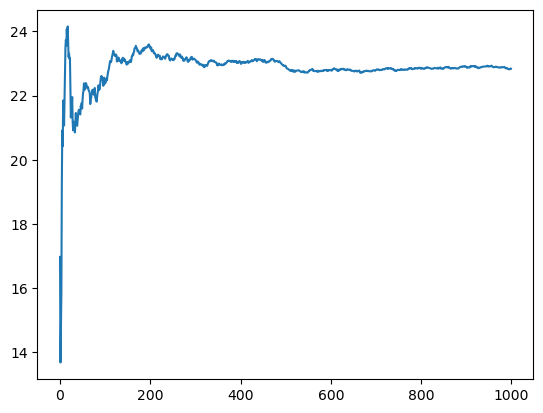

In [124]:
plt.figure()
plt.plot(train_utility, label='train')
plt.plot(test_utility, label='validation')
# plot a horizontal line for the optimal throughput with hline
plt.axhline(y=tput_optimal_mean, color='r', linestyle='-', label='optimal (exh. search)')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Sum rate, bits/s/Hz', fontsize=16)
plt.title("Utility")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot loss_train
axs[0].plot(loss_train, label='train')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot loss_test
axs[1].plot(loss_test, label='validation')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## MLP

In [ ]:
mlp_model = MLP(V_H).to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn = CustomLossBatch()
epochs = 100

train_utility, test_utility, loss_train, loss_test = train_handler(mlp_model, None, [], loss_fn, optimizer, train_loader, test_loader, epochs, "MLP", tau, max_iter, False, gumbel_samples, N, device)


### Draw loss and utility curve

In [ ]:
plt.figure()
plt.plot(train_utility, label='train')
plt.plot(test_utility, label='validation')
# plot a horizontal line for the optimal throughput with hline
plt.axhline(y=tput_optimal_mean, color='r', linestyle='-', label='optimal (exh. search)')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Sum rate, bits/s/Hz', fontsize=16)
plt.title("Utility")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot loss_train
axs[0].plot(loss_train, label='train')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot loss_test
axs[1].plot(loss_test, label='validation')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## HGNN + Gumble Trick

In [168]:
import torch

indices = torch.tensor([[0, 1, 1],
                        [2, 0, 2]], dtype=torch.long)  # must be long/int64
values  = torch.tensor([3, 4, 5], dtype=torch.float)
size    = (2, 3)

sparse_coo = torch.sparse_coo_tensor(indices, values, size).coalesce()
print(sparse_coo)


tensor(indices=tensor([[0, 1, 1],
                       [2, 0, 2]]),
       values=tensor([3., 4., 5.]),
       size=(2, 3), nnz=3, layout=torch.sparse_coo)


In [302]:
bn1 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64).to(device)  # dims match those of HGNN
bn2 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64).to(device)
bn_gumble = [bn1, bn2]

theta_HGNN_gumble = get_learnable_parameters(V_H, device)
gammas_list = [list(b.parameters()) for b in bn_gumble]
gammas_learnable = [q for p in gammas_list for q in p]
learnable_params = [nn.Parameter(theta) for theta in theta_HGNN_gumble] + gammas_learnable
optimizer = torch.optim.Adam(learnable_params, lr=0.01)

loss_fn = CustomLossBatch()


epochs = 5
#train_utility, test_utility, loss_train, loss_test = train_handler(HGNN, theta_HGNN_gumble, bn_gumble, loss_fn, optimizer, train_loader, test_loader, epochs, "HGNN", tau, max_iter, True, gumbel_samples, N, device)
train_utility, test_utility, loss_train, loss_test = train_handler_batch(HGNN, theta_HGNN_gumble, bn_gumble, loss_fn, optimizer, train_loader, test_loader, epochs, "HGNN", tau, max_iter, False, gumbel_samples, N, 64, device)

Initial utility per hypergraph in Training: 22.837225005278377
Initial utility per hypergraph in Testing: 19.522320212392362
Epoch: 0, Loss:-33.65406 | Train Utility: 22.83723, Feasibility: 1.00 | Test Utility: 19.52232, Feasibility: 1.00
Epoch: 1, Loss:-33.61944 | Train Utility: 22.83723, Feasibility: 1.00 | Test Utility: 19.52232, Feasibility: 1.00
Epoch: 2, Loss:-33.65427 | Train Utility: 22.83723, Feasibility: 1.00 | Test Utility: 19.52232, Feasibility: 1.00
Epoch: 3, Loss:-33.63222 | Train Utility: 22.83723, Feasibility: 1.00 | Test Utility: 19.52232, Feasibility: 1.00
Epoch: 4, Loss:-33.63858 | Train Utility: 22.83723, Feasibility: 1.00 | Test Utility: 19.52232, Feasibility: 1.00
Final utility per hypergraph: [14.110862267781005, 37.66693045215712, 14.255054770509044, 15.028421818307013, 16.550331753207622]


In [ ]:
test_utility

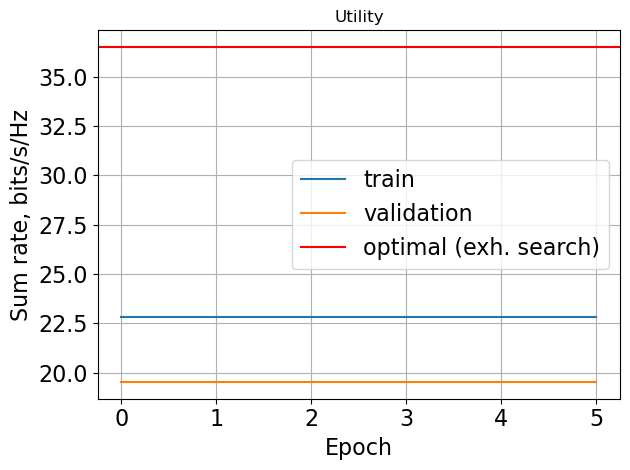

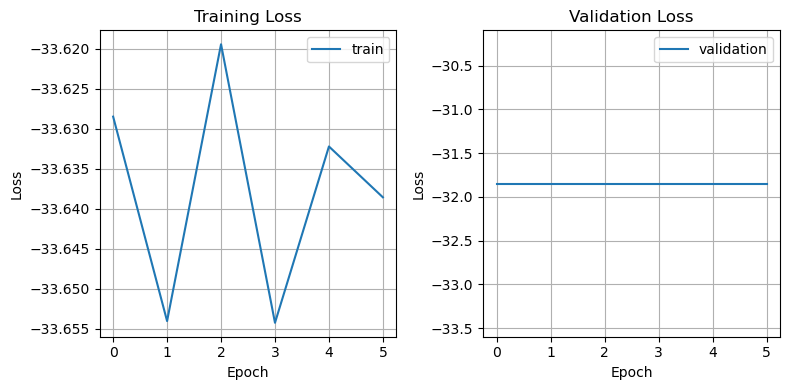

In [303]:
plt.figure()
plt.plot(train_utility, label='train')
plt.plot(test_utility, label='validation')
# plot a horizontal line for the optimal throughput with hline
plt.axhline(y=tput_optimal_mean, color='r', linestyle='-', label='optimal (exh. search)')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Sum rate, bits/s/Hz', fontsize=16)
plt.title("Utility")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot loss_train
axs[0].plot(loss_train, label='train')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot loss_test
axs[1].plot(loss_test, label='validation')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# Method Comparisons

## Exhaustive Search

In [127]:
exhaustive_utility = []
for (X, Dv_inv, De_inv, H, W) in test_dataset:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    # exhaustive search
    ex_ut = 0
    #for i in range(X.shape[0]):
    #    best_throughput, best_schedule = exh_solver(X.shape[1], X.shape[1], X.shape[1]*[N], X.detach().to_dense().numpy(), H.detach().to_dense().numpy())
    best_throughput, best_schedule = exh_solver(X.shape[1], X.shape[1], V_H*[N], X.cpu().detach().numpy(), H.cpu().detach().to_dense().numpy())
    ex_ut += best_throughput
    exhaustive_utility.append(ex_ut)
exhaustive_utility_mean = np.sum(exhaustive_utility)/test_samples
print(f"Utility exhaustive search: {exhaustive_utility_mean}")

Utility exhaustive search: 36.61259199482366


## HGNN + Linsat + Rounding

In [160]:
utility_test_base_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    H = H.T
    Dv_inv = Dv_inv.squeeze()
    De_inv = De_inv.squeeze()
    
    
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
    RHS_const = H.T.sum(dim=2).to_dense() - 1
    LHS_const = H.T.to_dense()
    RHS_const = RHS_const.squeeze(0)
    LHS_const = LHS_const.squeeze(0)
    z = z.unsqueeze(0)
    # Linsat 
    #z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = linsat_layer(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    # base utility
    # round z to the nearest integer
    zd = torch.round(z)
    utility_base = utility_fn(zd, X, N)
    utility_test_base_utility.append(utility_base.item())
utility_base = np.sum(utility_test_base_utility)/test_samples
print(f"Utility base: {utility_base}")

Utility base: 19.522320212392362


## HGNN + Linsat + Greedy 1

In [161]:
# without utility function
utility_test_wo_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    H = H.T
    Dv_inv = Dv_inv.squeeze()
    De_inv = De_inv.squeeze()
    
    
    
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
    RHS_const = H.T.sum(dim=2).to_dense() - 1
    LHS_const = H.T.to_dense()
    RHS_const = RHS_const.squeeze(0)
    LHS_const = LHS_const.squeeze(0)
    z = z.unsqueeze(0)
    # Linsat 
    #z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = linsat_layer(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()

    # wo utility
    zwo = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1).to_dense(), H.T.to('cpu').to_dense(), N, False)
    utility_wo = utility_fn(zwo, X.to('cpu'), N)
    utility_test_wo_utility.append(utility_wo.item())
utility_test_wo_mean = np.sum(utility_test_wo_utility)/test_samples
print(f"Utility without utility function: {utility_test_wo_mean}")

Utility without utility function: 32.392976272014394


## HGNN + Linsat + Greedy 2

In [151]:
utility_test_w_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    H = H.T
    Dv_inv = Dv_inv.squeeze()
    De_inv = De_inv.squeeze()
    
    
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
    RHS_const = H.T.sum(dim=2).to_dense() - 1
    LHS_const = H.T.to_dense()
    RHS_const = RHS_const.squeeze(0)
    LHS_const = LHS_const.squeeze(0)
    z = z.unsqueeze(0)
    # Linsat 
    #z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = linsat_layer(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    # w utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.T.to('cpu').to_dense(), N, True)
    utility_w = utility_fn(zw, X.to('cpu'), N)
    utility_test_w_utility.append(utility_w.item())
utility_test_w_mean = np.sum(utility_test_w_utility)/test_samples
print(f"Utility with utility function: {utility_test_w_mean}")

Utility with utility function: 33.214788038393806


## Greedy 1

In [148]:
utility_test_greedy1 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = torch.ones([X.shape[0], V_H])
    # w utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').to_dense(), N, False)
    utility_w = utility_fn(zw, X.to('cpu'), N)
    utility_test_greedy1.append(utility_w.item())
utility_test_greedy1_mean = np.sum(utility_test_greedy1)/test_samples
print(f"Utility greedy 1 only: {utility_test_greedy1_mean}")

Utility greedy 1 only: 32.392976272014394


## Greedy 2

In [150]:
utility_test_greedy2 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = torch.ones([X.shape[0], V_H])
    # w utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').to_dense(), N, True)
    utility_w = utility_fn(zw, X.to('cpu'), N)
    utility_test_greedy2.append(utility_w.item())
utility_test_greedy2_mean = np.sum(utility_test_greedy2)/test_samples
print(f"Utility greedy 2 only: {utility_test_greedy2_mean}")

Utility greedy 2 only: 34.5429938798427


## MLP + Linsat + Rounding

In [ ]:
utility_test_mlp = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = mlp_model(X.view(-1, V_H*V_H))

    # Linsat 
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    # base utility
    # round z to the nearest integer
    zd = torch.round(z)
    utility_mlp = utility_fn(zd, X, N)
    utility_test_mlp.append(utility_mlp.item())
utility_base_mlp = np.sum(utility_test_mlp)/test_samples
print(f"Utility MLP base: {utility_base_mlp}")

## MLP + LinSat + Greedy 1

In [ ]:
utility_test_mlp_greedy1 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = mlp_model(X.view(-1, V_H*V_H))

    # Linsat 
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()

    # base utility
    zwo = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, False)
    utility_mlp = utility_fn(zwo, X, N)
    utility_test_mlp_greedy1.append(utility_mlp.item())
utility_mlp_greedy1 = np.sum(utility_test_mlp_greedy1)/test_samples
print(f"Utility MLP + Greedy 1: {utility_mlp_greedy1}")

## MLP + LinSat + Greedy 2

In [ ]:
utility_test_mlp_greedy2 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = mlp_model(X.view(-1, V_H*V_H))

    # Linsat 
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()

    # base utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, True)
    utility_mlp = utility_fn(zw, X, N)
    utility_test_mlp_greedy2.append(utility_mlp.item())
utility_mlp_greedy2 = np.sum(utility_test_mlp_greedy2)/test_samples
print(f"Utility MLP + Greedy 2: {utility_mlp_greedy2}")

## HGNN + Gumbel + Linsat + Rounding + Max (HGL)

In [ ]:
utility_gumbel_base_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
    # Linsat 
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = gumbel_linsat_layer(z, A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, noise_fact=1., sample_num=gumbel_samples)
    # base utility
    # round z to the nearest integer
    utility_max = torch.zeros(z.shape[1])
    for i in range(z.shape[0]):
        #z_mlp = gready_scheduler(z[i], X, H, N, True)

        # keep the maximum utility
        utility_max = torch.max(utility_max, utility_fn(torch.round(z[i]), X, N))
    utility_max = utility_max.mean()
    utility_gumbel_base_utility.append(utility_max.item())
utility_base_gumbel = np.sum(utility_gumbel_base_utility)/test_samples
print(f"Utility Gumbel Base: {utility_base_gumbel}")

## HGNN + Gumbel + Linsat + Greedy 1 (HGL+Greedy1)

In [ ]:
utility_gumbel_greedy1 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
    # Linsat 
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = gumbel_linsat_layer(z, A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, noise_fact=1., sample_num=gumbel_samples)
    # base utility
    # round z to the nearest integer
    utility_max = torch.zeros(z.shape[1])
    for i in range(z.shape[0]):
        #z_mlp = gready_scheduler(z[i], X, H, N, True)

        # keep the maximum utility
        zwo = gready_scheduler(z[i].to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, False)
        utility_max = torch.max(utility_max, utility_fn(zwo, X, N))
    utility_max = utility_max.mean()
    utility_gumbel_greedy1.append(utility_max.item())
utility_gumbel_greedy1 = np.sum(utility_gumbel_greedy1)/test_samples
print(f"Utility Gumbel Greedy 1: {utility_gumbel_greedy1}")

## HGNN + Gumbel + Linsat + Greedy 2 (HGL+Greedy2)

In [ ]:
utility_gumbel_greedy2 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
    # Linsat 
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = gumbel_linsat_layer(z, A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, noise_fact=1., sample_num=gumbel_samples)
    # base utility
    # round z to the nearest integer
    utility_max = torch.zeros(z.shape[1])
    for i in range(z.shape[0]):
        #z_mlp = gready_scheduler(z[i], X, H, N, True)

        # keep the maximum utility
        zwo = gready_scheduler(z[i].to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, True)
        utility_max = torch.max(utility_max, utility_fn(zwo, X, N))
    utility_max = utility_max.mean()
    utility_gumbel_greedy2.append(utility_max.item())
utility_gumbel_greedy2 = np.sum(utility_gumbel_greedy2)/test_samples
print(f"Utility Gumbel Greedy 2: {utility_gumbel_greedy2}")

## APOPT Solver

In [ ]:
apopt_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    ex_ut = 0
    for i in range(X.shape[0]):
        best_throughput = gekko_apopt_solver(X.shape[1], X.shape[1], V_H*[N], X[i].cpu().detach().numpy(), H[i].cpu().detach().numpy())
        ex_ut += best_throughput
    apopt_utility.append(ex_ut)
apopt_utility = np.sum(apopt_utility)/test_samples
print(f"Utility of APOPT: {apopt_utility}")

# Plots

In [ ]:
import matplotlib.pyplot as plt

## Extensions

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

# Data for plotting
utilities = {
    'GREEDY1': utility_test_greedy1_mean,
    'GREEDY2': utility_test_greedy2_mean,
    "HGNN": utility_base,
    "HGNN+GREEDY1": utility_test_wo_mean,
    "HGNN+GREEDY2": utility_test_w_mean,
    "MLP": utility_base_mlp,
    "MLP+GREEDY1": utility_mlp_greedy1,
    "MLP+GREEDY2": utility_mlp_greedy2,
    "HGL": utility_base_gumbel,
    "HGL+GREEDY1": utility_gumbel_greedy1,
    "HGL+GREEDY2": utility_gumbel_greedy2,
    "APOPT": apopt_utility,
    "EXH Search": exhaustive_utility_mean
}

# Create a DataFrame for seaborn
df_utilities = pd.DataFrame(list(utilities.items()), columns=['Type', 'Value'])

# Plotting with smaller size and numbers on top
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Type', y='Value', data=df_utilities, palette='viridis', width=0.3)
plt.title('Comparison of Utilities')
plt.xlabel('Methods')
plt.ylabel('Sum rate, bits/s/Hz')
plt.xticks(rotation=45)
plt.grid(False)

# Adding the values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2, p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
plt.xticks(fontsize=9)

plt.savefig('tput_bar.jpg', bbox_inches='tight')
plt.show()

## Runtime

In [ ]:
x = [10, 15, 20]
tput_exh = [34.706, 35.016, 35.278]
tput_hgnn = [9.360, 10.887, 10.155]
runtime_exh = [0.01215, 0.3982, 11.5749]
runtime_hgnn = [0.052, 0.071, 0.090]


In [ ]:
x = np.array(x)
width = 1.5

plt.bar(x - width/2, tput_exh, width, label="Exh. search")
plt.bar(x + width/2, tput_hgnn, width, label="HGNN")

# Add labels and legend
plt.xlabel("Number of nodes")
plt.ylabel("Sum rate, bits/s/Hz")
plt.xticks(x)
plt.legend()
plt.tight_layout()
# plt.savefig('sumrate_bar.jpg')
plt.show()

In [ ]:
x = np.array(x)
width = 1.5

plt.bar(x - width/2, runtime_exh, width, label="Exh. search")
plt.bar(x + width/2, runtime_hgnn, width, label="HGNN")

# Add labels and legend
plt.xlabel("Number of nodes")
plt.ylabel("Runtime, seconds")
plt.xticks(x)
plt.legend()
plt.tight_layout()
# plt.savefig('runtime_bar.jpg')
plt.show()

# Comparing HGNN with MLP

In [ ]:
from datasetgen import get_hyper_dataset
from tqdm import tqdm

hgnn_perf = []
mlp_perf = []
batch_size = 64
xy_lim = 4000
for _ in tqdm(range(100)):
    dataset_samples = get_hyper_dataset(V_H, N, xy_lim, theta, k, 100)

    sample_loader = DataLoader(dataset_samples, batch_size=batch_size, shuffle=False)

    utility_test_wo_utility = []
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
        # Linsat 
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        # wo utility
        zwo = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, False)
        utility_wo = utility_fn(zwo, X.to('cpu'), N)
        utility_test_wo_utility.append(utility_wo.item())
    utility_test_wo_mean = np.sum(utility_test_wo_utility)/len(dataset_samples)
    hgnn_perf.append(utility_test_wo_mean)


    utility_test_mlp_greedy1 = []
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = mlp_model(X.view(-1, V_H*V_H))

        # Linsat 
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()

        # base utility
        zwo = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, False)
        utility_mlp = utility_fn(zwo, X, N)
        utility_test_mlp_greedy1.append(utility_mlp.item())
    utility_mlp_greedy1 = np.sum(utility_test_mlp_greedy1)/len(dataset_samples)

    mlp_perf.append(utility_mlp_greedy1)

    



    


In [ ]:
# Combine data into a DataFrame
data = pd.DataFrame({
    "Model": ["MLP"] * len(mlp_perf) + ["HGNN"] * len(hgnn_perf),
    "Performance": mlp_perf + hgnn_perf
})

# Create the barplot
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Performance", data=data, ci=None, palette="viridis")

# Calculate mean values
mlp_mean = np.mean(mlp_perf)
hgnn_mean = np.mean(hgnn_perf)

# Annotate the mean values on the bars
plt.text(0, mlp_mean + 0.01, f'{mlp_mean:.2f}', ha='center', va='bottom', fontsize=12, color='black')
plt.text(1, hgnn_mean + 0.01, f'{hgnn_mean:.2f}', ha='center', va='bottom', fontsize=12, color='black')

# Add labels and title
plt.title("Performance of MLP and HGNN", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Performance", fontsize=12)

plt.show()